In [30]:
import pandas as pd
import numpy as np
import itertools
from random import randint
from datetime import datetime, date
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
import matplotlib.pyplot as plt

## Data Cleaning

In [2]:
CustomerDemographic = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx', 'CustomerDemographic', 1)
CustomerAddress = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx', 'CustomerAddress', 1)
Transactions = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx', 'Transactions', 1)

In [3]:
# Remove Transactions that were Cancelled
print(np.unique(Transactions.order_status, return_counts=True))
Transactions = Transactions[Transactions.order_status == 'Approved']
len(Transactions)

(array(['Approved', 'Cancelled'], dtype=object), array([19821,   179], dtype=int64))


19821

In [4]:
# Create new column to sum up purchases made by same customer
Transactions['purchases'] = np.ones(len(Transactions))
# Create prediction value based on list_price & standard_cost
Transactions['value'] = Transactions['list_price'] - Transactions['standard_cost']
trans_temp = Transactions.groupby('customer_id').agg('sum')
trans_temp.head()

,transaction_id,product_id,online_order,list_price,standard_cost,product_first_sold_date,purchases,value
customer_id,,,,,,,,
1,126342,376,6.0,9084.45,6066.36,410455.0,11.0,3018.09
2,25415,112,1.0,4149.07,1922.81,116327.0,3.0,2226.26
3,110741,483,1.0,9888.23,6525.42,314802.0,8.0,3362.81
4,27089,157,1.0,1047.72,827.15,72017.0,2.0,220.57
5,47818,289,2.0,5903.20,3508.26,224166.0,6.0,2394.94


### Merge all training data into single dataframe

In [5]:
temp = trans_temp.merge(CustomerAddress, how='inner',on='customer_id')
train = temp.merge(CustomerDemographic, how='inner',on='customer_id')
train

,customer_id,transaction_id,product_id,online_order,list_price,standard_cost,product_first_sold_date,purchases,value,address,...,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure
0,1,126342,376,6.0,9084.45,6066.36,410455.0,11.0,3018.09,060 Morning Avenue,...,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,"""'",Yes,11.0
1,2,25415,112,1.0,4149.07,1922.81,116327.0,3.0,2226.26,6 Meadow Vale Court,...,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,<script>alert('hi')</script>,Yes,16.0
2,4,27089,157,1.0,1047.72,827.15,72017.0,2.0,220.57,0 Holy Cross Court,...,Male,33,1961-10-03,NaN,IT,Mass Customer,N,() { _; } >_[$($())] { touch /tmp/blns.shellsh...,No,7.0
3,5,47818,289,2.0,5903.20,3508.26,224166.0,6.0,2394.94,17979 Del Mar Point,...,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,NIL,Yes,8.0
4,6,25964,143,2.0,5931.69,1985.14,194209.0,5.0,3946.55,9 Oakridge Court,...,Male,35,1966-09-16,NaN,Retail,High Net Worth,N,ðµ ð ð ð,Yes,13.0
5,7,40872,99,2.0,995.38,775.27,118161.0,3.0,220.11,4 Delaware Trail,...,Female,6,1976-02-23,NaN,Financial Services,Affluent Customer,N,â°â´âµâââ,Yes,11.0
6,8,110224,274,5.0,12024.76,4957.82,392332.0,10.0,7066.94,49 Londonderry Lane,...,Male,31,1962-03-30,Media Manager I,NaN,Mass Customer,N,(â¯Â°â¡Â°ï¼â¯ï¸µ â»ââ»),No,7.0
7,9,38371,293,1.0,5357.55,3004.44,242834.0,6.0,2353.11,97736 7th Trail,...,Female,97,1973-03-10,Business Systems Development Analyst,Argiculture,Affluent Customer,N,0/0,Yes,8.0
8,11,75783,167,2.0,6779.44,3140.60,231200.0,6.0,3638.84,93405 Ludington Park,...,Male,99,1954-04-30,NaN,Property,Mass Customer,N,ÅâÂ´Â®â Â¥Â¨ËÃ¸Ïââ,No,9.0
9,12,78960,380,3.0,6394.21,2854.18,273948.0,7.0,3540.03,44339 Golden Leaf Alley,...,Male,58,1994-07-21,Nuclear Power Engineer,Manufacturing,Mass Customer,N,nil,No,8.0


In [6]:
# Convert DOB to Age
age = [pd.to_datetime('today').year - pd.to_datetime(i).year for i in train.DOB]
train['age'] = age
# Standardize inputs in state column
train.loc[train['state']=='New South Wales','state'] = 'NSW'
train.loc[train['state']=='Victoria','state'] = 'VIC'
# Standardize inputs in gender column
train.loc[train['gender']=='F','gender'] = 'Female'
train.loc[train['gender']=='Femal','gender'] = 'Female'
train.loc[train['gender']=='M','gender'] = 'Male'
train.loc[train['gender']=='U','gender'] = 'Male'
train.head()

,customer_id,transaction_id,product_id,online_order,list_price,standard_cost,product_first_sold_date,purchases,value,address,...,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure,age
0,1,126342,376,6.0,9084.45,6066.36,410455.0,11.0,3018.09,060 Morning Avenue,...,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,"""'",Yes,11.0,67.0
1,2,25415,112,1.0,4149.07,1922.81,116327.0,3.0,2226.26,6 Meadow Vale Court,...,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,<script>alert('hi')</script>,Yes,16.0,40.0
2,4,27089,157,1.0,1047.72,827.15,72017.0,2.0,220.57,0 Holy Cross Court,...,33,1961-10-03,NaN,IT,Mass Customer,N,() { _; } >_[$($())] { touch /tmp/blns.shellsh...,No,7.0,59.0
3,5,47818,289,2.0,5903.20,3508.26,224166.0,6.0,2394.94,17979 Del Mar Point,...,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,NIL,Yes,8.0,43.0
4,6,25964,143,2.0,5931.69,1985.14,194209.0,5.0,3946.55,9 Oakridge Court,...,35,1966-09-16,NaN,Retail,High Net Worth,N,ðµ ð ð ð,Yes,13.0,54.0


In [7]:
# Remove Transactions that were from deceased 
print(np.unique(train.deceased_indicator, return_counts=True))
train = train[train.deceased_indicator == 'N']
len(train)

(array(['N', 'Y'], dtype=object), array([3487,    1], dtype=int64))


3487

### Choose Potential Predictor columns

In [8]:
#train_1 = train[['gender','age','past_3_years_bike_related_purchases','wealth_segment','owns_car','tenure','state','property_valuation','job_title','job_industry_category','value']]
train_1 = train[['gender','age','past_3_years_bike_related_purchases','wealth_segment','owns_car','tenure','state','property_valuation','job_industry_category','value']]

train_1.isna().sum()

gender                                   0
age                                     76
past_3_years_bike_related_purchases      0
wealth_segment                           0
owns_car                                 0
tenure                                  76
state                                    0
property_valuation                       0
job_industry_category                  560
value                                    0
dtype: int64

In [9]:
# Removed Nan rows as its a small portion of training data
train_1 = train_1.dropna(subset=['age','tenure','value'])
train_1.isna().sum()

gender                                   0
age                                      0
past_3_years_bike_related_purchases      0
wealth_segment                           0
owns_car                                 0
tenure                                   0
state                                    0
property_valuation                       0
job_industry_category                  560
value                                    0
dtype: int64

In [10]:
np.unique(train_1.gender, return_counts=True)

(array(['Female', 'Male'], dtype=object), array([1756, 1655], dtype=int64))

In [11]:
# Remove outlier of age=177
max_age = train_1['age'].max()
train_1 = train_1[train_1['age']<max_age]
train_1['age'].hist()

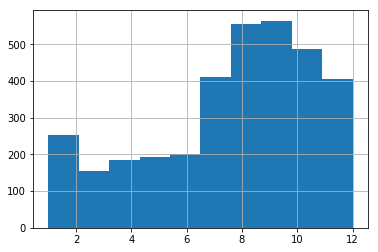

In [12]:
train_1['property_valuation'].hist()

## Categorical Data

In [13]:
train_1.loc[train_1['state']=='New South Wales','state'] = 'NSW'
train_1.loc[train_1['state']=='Victoria','state'] = 'VIC'
np.unique(train_1.state, return_counts=True)

(array(['NSW', 'QLD', 'VIC'], dtype=object),
 array([1822,  728,  860], dtype=int64))

In [14]:
from sklearn.preprocessing import LabelEncoder 
# Create labels for categories
le_gender = LabelEncoder()
train_1['gender']= le_gender.fit_transform(train_1['gender'])
le_wealth = LabelEncoder()
train_1['wealth_segment']= le_wealth.fit_transform(train_1['wealth_segment'])
le_owns = LabelEncoder()
train_1['owns_car']= le_owns.fit_transform(train_1['owns_car'])
le_state = LabelEncoder()
train_1['state']= le_state.fit_transform(train_1['state'])
train_1.head()

,gender,age,past_3_years_bike_related_purchases,wealth_segment,owns_car,tenure,state,property_valuation,job_industry_category,value
0,0,67.0,93,2,1,11.0,0,10,Health,3018.09
1,1,40.0,81,2,1,16.0,0,10,Financial Services,2226.26
2,1,59.0,33,2,0,7.0,1,9,IT,220.57
3,0,43.0,56,0,1,8.0,0,4,NaN,2394.94
4,1,54.0,35,1,1,13.0,2,9,Retail,3946.55


In [15]:
# Create age bracket
age_bracket = []
for x in train_1.age:
    if x < 10:
        age_bracket.append(0)
    elif x>=10 and x<20:
        age_bracket.append(1)
    elif x>=20 and x<30:
        age_bracket.append(2)
    elif x>=30 and x<40:
        age_bracket.append(3)
    elif x>=40 and x<50:
        age_bracket.append(4)
    elif x>=50 and x<60:
        age_bracket.append(5)
    elif x>=60 and x<70:
        age_bracket.append(6)
    elif x>=70 and x<80:
        age_bracket.append(7)
    elif x>=80 and x<90:
        age_bracket.append(8)
train_1['age_bracket'] = age_bracket
train_1 = train_1.drop(columns = ['age'])

In [16]:
# Create a set of dummy variables
#df_train = pd.get_dummies(train_1, columns=['job_title','job_industry_category'])
df_train = pd.get_dummies(train_1, columns=['job_industry_category'])
df_train.head()

,gender,past_3_years_bike_related_purchases,wealth_segment,owns_car,tenure,state,property_valuation,value,age_bracket,job_industry_category_Argiculture,job_industry_category_Entertainment,job_industry_category_Financial Services,job_industry_category_Health,job_industry_category_IT,job_industry_category_Manufacturing,job_industry_category_Property,job_industry_category_Retail,job_industry_category_Telecommunications
0,0,93,2,1,11.0,0,10,3018.09,6,0,0,0,1,0,0,0,0,0
1,1,81,2,1,16.0,0,10,2226.26,4,0,0,1,0,0,0,0,0,0
2,1,33,2,0,7.0,1,9,220.57,5,0,0,0,0,1,0,0,0,0
3,0,56,0,1,8.0,0,4,2394.94,4,0,0,0,0,0,0,0,0,0
4,1,35,1,1,13.0,2,9,3946.55,5,0,0,0,0,0,0,0,1,0


In [17]:
X = df_train.drop(columns=['value'])
y = df_train['value']

In [18]:
def get_cv_mse(x,y,d):
    # DecisionTreeRegressor Mean Cross Validation Score and Feature Importance
    dt =  DecisionTreeRegressor(max_depth=d)
    dt_cv_mse = cross_val_score(dt, x, y,scoring='neg_mean_squared_error',cv=5)
    mean_cv_mse = dt_cv_mse.mean()
    features = []
    # 
    temp = dt.fit(x, y).feature_importances_
    for i in temp[temp!=0]:
        # Obtain features and importance score
        features.append((i,X.columns[list(temp).index(i)]))
    return mean_cv_mse, features

In [19]:
# Initialize list to save test results
depth, score, features = [], [], []
for i in range (1,11):
    temp_score, temp_features = get_cv_mse(X,y,i)
    depth.append(i)
    score.append(temp_score)
    features.append(temp_features)

In [20]:
df = pd.DataFrame()
df['Depth'] = depth
df['MSE'] = score
df['Feature'] = features
df

,Depth,MSE,Feature
0,1,-3.125164e+06,"[(1.0, past_3_years_bike_related_purchases)]"
1,2,-3.133922e+06,"[(0.7448654087348027, past_3_years_bike_relate..."
2,3,-3.174389e+06,"[(0.2809124164330101, past_3_years_bike_relate..."
3,4,-3.185264e+06,"[(0.20958571339584917, past_3_years_bike_relat..."
4,5,-3.271629e+06,"[(0.11085453966717516, past_3_years_bike_relat..."
5,6,-3.366670e+06,"[(0.01355840515828614, gender), (0.16488094576..."
6,7,-3.498091e+06,"[(0.018894521001841712, gender), (0.2426239730..."
7,8,-3.685695e+06,"[(0.0332084112919853, gender), (0.220759011070..."
8,9,-3.949324e+06,"[(0.034155715115537576, gender), (0.2382788622..."
9,10,-4.237018e+06,"[(0.03301642630588159, gender), (0.22755620937..."


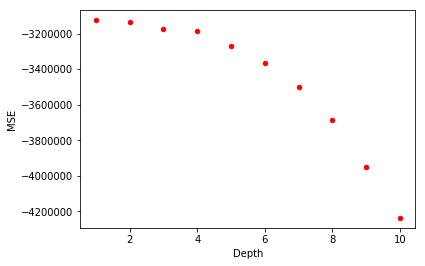

In [21]:
df.plot(kind='scatter',x='Depth',y='MSE',color='red')

In [22]:
# Choose Depth = 3 
df.loc[2].Feature

[(0.2809124164330101, 'past_3_years_bike_related_purchases'),
 (0.22175637818343422, 'owns_car'),
 (0.0962193621917091, 'tenure'),
 (0.13646527274445988, 'property_valuation'),
 (0.18190264223708713, 'age_bracket'),
 (0.08274392821029944, 'job_industry_category_Financial Services')]

In [23]:
dt =  DecisionTreeRegressor(max_depth=3).fit(X,y)

In [24]:
temp = dt.feature_importances_
for i in temp[temp!=0]:
        # Obtain features and importance score
        print((i,X.columns[list(temp).index(i)]))

(0.2809124164335592, 'past_3_years_bike_related_purchases')
(0.22175637818364877, 'owns_car')
(0.09621936219175442, 'tenure')
(0.13646527274397052, 'property_valuation')
(0.18190264223634023, 'age_bracket')
(0.08274392821072685, 'job_industry_category_Financial Services')


In [33]:
X.columns

Index(['gender', 'past_3_years_bike_related_purchases', 'wealth_segment',
       'owns_car', 'tenure', 'state', 'property_valuation', 'age_bracket',
       'job_industry_category_Argiculture',
       'job_industry_category_Entertainment',
       'job_industry_category_Financial Services',
       'job_industry_category_Health', 'job_industry_category_IT',
       'job_industry_category_Manufacturing', 'job_industry_category_Property',
       'job_industry_category_Retail',
       'job_industry_category_Telecommunications'],
      dtype='object')

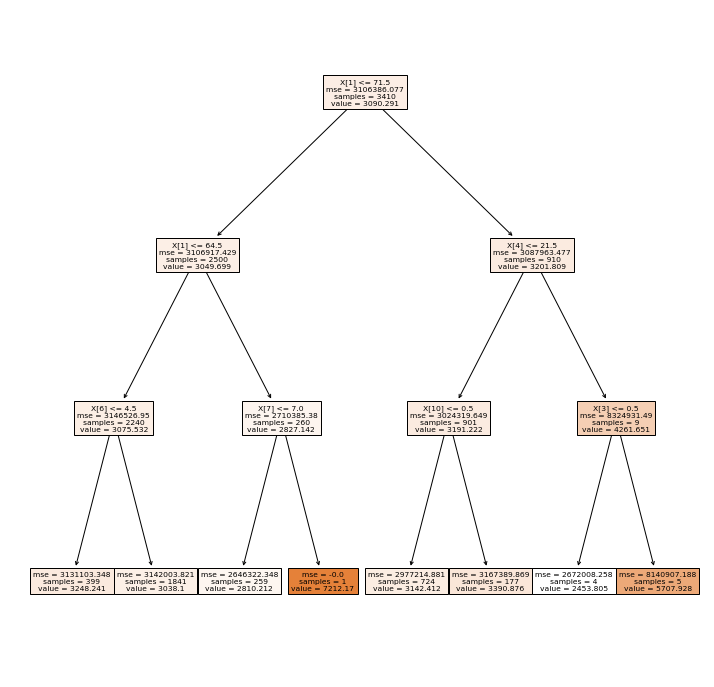

In [32]:
fig, ax = plt.subplots(figsize=(12, 12))
tree.plot_tree(dt, filled=True)
plt.show()

## Test Data Prediction

In [140]:
test = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx', 'NewCustomerList', 1)
test

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,...,state,country,property_valuation,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Rank,Value
0,Chickie,Brister,Male,86,1957-07-12,General Manager,Manufacturing,Mass Customer,N,Yes,...,QLD,Australia,6,0.41,0.5125,0.640625,0.544531,1,1,1.718750
1,Morly,Genery,Male,69,1970-03-22,Structural Engineer,Property,Mass Customer,N,No,...,NSW,Australia,11,0.41,0.4100,0.512500,0.435625,1,1,1.718750
2,Ardelis,Forrester,Female,10,1974-08-28,Senior Cost Accountant,Financial Services,Affluent Customer,N,No,...,VIC,Australia,5,0.53,0.5300,0.530000,0.530000,1,1,1.718750
3,Lucine,Stutt,Female,64,1979-01-28,Account Representative III,Manufacturing,Affluent Customer,N,Yes,...,QLD,Australia,1,0.55,0.6875,0.687500,0.687500,4,4,1.703125
4,Melinda,Hadlee,Female,34,1965-09-21,Financial Analyst,Financial Services,Affluent Customer,N,No,...,NSW,Australia,9,0.68,0.6800,0.850000,0.850000,4,4,1.703125
5,Druci,Brandli,Female,39,1951-04-29,Assistant Media Planner,Entertainment,High Net Worth,N,Yes,...,QLD,Australia,7,0.50,0.6250,0.625000,0.625000,6,6,1.671875
6,Rutledge,Hallt,Male,23,1976-10-06,Compensation Analyst,Financial Services,Mass Customer,N,No,...,NSW,Australia,7,0.60,0.6000,0.600000,0.510000,6,6,1.671875
7,Nancie,Vian,Female,74,1972-12-27,Human Resources Assistant II,Retail,Mass Customer,N,Yes,...,QLD,Australia,5,1.04,1.3000,1.300000,1.105000,8,8,1.656250
8,Duff,Karlowicz,Male,50,1972-04-28,Speech Pathologist,Manufacturing,Mass Customer,N,Yes,...,NSW,Australia,10,0.62,0.7750,0.968750,0.823437,8,8,1.656250
9,Barthel,Docket,Male,72,1985-08-02,Accounting Assistant IV,IT,Mass Customer,N,Yes,...,QLD,Australia,5,0.75,0.9375,0.937500,0.796875,10,10,1.640625


In [144]:
test_1 = test[['gender','DOB','past_3_years_bike_related_purchases','wealth_segment','owns_car','tenure','state','property_valuation','job_industry_category']]
test_1.isna().sum()

gender                                   0
DOB                                     17
past_3_years_bike_related_purchases      0
wealth_segment                           0
owns_car                                 0
tenure                                   0
state                                    0
property_valuation                       0
job_industry_category                  165
dtype: int64

In [145]:
# Convert DOB to Age
age = [pd.to_datetime('today').year - pd.to_datetime(i).year for i in test_1.DOB]
test_1['age'] = age
test_1 = test_1.drop(columns=['DOB'])
# Standardize inputs in state column
test_1.loc[test_1['state']=='New South Wales','state'] = 'NSW'
test_1.loc[test_1['state']=='Victoria','state'] = 'VIC'
# Standardize inputs in gender column
test_1.loc[test_1['gender']=='F','gender'] = 'Female'
test_1.loc[test_1['gender']=='Femal','gender'] = 'Female'
test_1.loc[test_1['gender']=='M','gender'] = 'Male'
test_1.loc[test_1['gender']=='U','gender'] = 'Male'
age_bracket = []
# Create age bracket
age_bracket = []
for x in test_1.age:
    if x < 10:
        age_bracket.append(0)
    elif x>=10 and x<20:
        age_bracket.append(1)
    elif x>=20 and x<30:
        age_bracket.append(2)
    elif x>=30 and x<40:
        age_bracket.append(3)
    elif x>=40 and x<50:
        age_bracket.append(4)
    elif x>=50 and x<60:
        age_bracket.append(5)
    elif x>=60 and x<70:
        age_bracket.append(6)
    elif x>=70 and x<80:
        age_bracket.append(7)
    elif x>=80 and x<90:
        age_bracket.append(8)
    else:
        age_bracket.append(4)
test_1['age_bracket'] = age_bracket
test_1 = test_1.drop(columns = ['age'])
test_1['owns_car']= le_owns.transform(test_1['owns_car'])
test_1['gender']= le_gender.transform(test_1['gender'])
test_1['wealth_segment']= le_wealth.transform(test_1['wealth_segment'])
test_1['state']= le_state.transform(test_1['state'])
df_test = pd.get_dummies(test_1, columns=['job_industry_category'])
# Create a set of dummy variables
#df_test = test_1.copy()
df_test.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,gender,past_3_years_bike_related_purchases,wealth_segment,owns_car,tenure,state,property_valuation,age_bracket,job_industry_category_Argiculture,job_industry_category_Entertainment,job_industry_category_Financial Services,job_industry_category_Health,job_industry_category_IT,job_industry_category_Manufacturing,job_industry_category_Property,job_industry_category_Retail,job_industry_category_Telecommunications
0,1,86,2,1,14,1,6,6,0,0,0,0,0,1,0,0,0
1,1,69,2,0,16,0,11,5,0,0,0,0,0,0,1,0,0
2,0,10,0,0,10,2,5,4,0,0,1,0,0,0,0,0,0
3,0,64,0,1,5,1,1,4,0,0,0,0,0,1,0,0,0
4,0,34,0,0,19,0,9,5,0,0,1,0,0,0,0,0,0


In [146]:
len(df_test.columns)

17

In [147]:
predictions = dt.predict(df_test)

In [150]:
test['Predict'] = predictions
test[['past_3_years_bike_related_purchases','owns_car','DOB','property_valuation','Rank','Value','Predict']].sort_values('Predict',ascending=False)

,past_3_years_bike_related_purchases,owns_car,DOB,property_valuation,Rank,Value,Predict
689,69,Yes,1938-09-02,9,688,0.697000,7212.170000
857,67,Yes,1939-11-08,9,856,0.560000,7212.170000
200,70,Yes,1940-12-05,7,201,1.142187,7212.170000
18,65,Yes,1938-11-09,11,19,1.531250,7212.170000
807,67,No,1940-11-25,11,808,0.595000,7212.170000
981,83,Yes,1951-08-23,1,979,0.416500,5707.928000
384,82,Yes,1995-05-18,6,382,0.950000,3390.875932
714,74,No,1950-10-12,11,715,0.677344,3390.875932
418,76,Yes,1998-01-12,10,419,0.916406,3390.875932
742,97,Yes,2001-04-16,6,741,0.658750,3390.875932
